In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Homework 7

# I still have 3 and 5 to do #

# Function Definitions #

In [2]:
def k_means(X,k,max_it=1000000):   
    it = 0 
    m,n = X.shape #dataset size, number of features
    repeat = True 
    'random initialization of clusters'
    clusters = np.random.randint(k,size=len(X)) # random assignment
    'means initialization'
    means = np.zeros((k,n))
    while repeat and it<=max_it: # repeat until clusters do not change or iterations > max_it
        it = it + 1
        'step 1: update means'
        for i in range(k):
            if len(X[clusters==i])!=0:
                means[i] = np.mean(X[clusters==i],axis=0)
            else: # if any of the cluster centers has no data points associated with it, replace it with a random data point
                idx = np.random.randint(m)
                means[i] = X[idx]
        'step 2: update clusters'
        new_clusters = np.argmin(np.array([np.linalg.norm(X-means[i],axis=1) for i in range(k)]),axis=0)        
        'check whether clusters and new_clusters are equal or not'
        if sum(clusters!=new_clusters)==0:
            repeat = False
        clusters = new_clusters
    return clusters, means

def inertia(X,k,clusters,means):
    m = X.shape[0] #dataset size
    inertia = 0
    for i in range(k): # iterate over clusters
        distances = np.square(np.linalg.norm(X[clusters==i]-means[i],axis=1)) # distances from points in cluster i to cluster i mean
        inertia = inertia + np.sum(distances)
    inertia = inertia/m
    return inertia

'Intercluster distance function'
def cluster_distance_min(cluster1, cluster2):
    s1 = cluster1.shape[0] #size of cluster 1
    s2 = cluster2.shape[0] #size of cluster 2
    'compute all the pairwise distances between points in cluster1 and points in cluster2'
    distances = np.array([np.linalg.norm(cluster1[i]-cluster2[j]) for i in range(s1) for j in range(s2)])
    'return the minimum distance'
    return np.min(distances)

def hierarchical_clustering(X,n_clusters=1):   
    
    m,n = X.shape #dataset size, number of features
    
    'Make each point its own cluster of one'
    k = m # number of clusters
    clusters = np.arange(k) 
    
    'distance between clusters initialization'
    distance_clusters = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            distance_clusters[i,j] = np.linalg.norm(X[i]-X[j]) # Euclidean distance between point i and point j
    np.fill_diagonal(distance_clusters, np.inf) #set diagonal entries to infinity
    
    'hierarchical clustering iteration'
    while k>n_clusters:     
        'find closest clusters'
        result = np.where(distance_clusters==np.amin(distance_clusters))
        i,j = result[0][0],result[1][0]
        i,j = np.sort([i,j]) # reorder the pair (i,j) so that  j>i
        
        'merge clusters i and j'
        clusters[clusters==j]=i
        
        'rename clusters'
        for idx in range(j+1,k):
            clusters[clusters==idx]=idx-1
            
        'recompute distance from the new cluster i to the remaining clusters'
        distance_clusters[i] = np.minimum(distance_clusters[i],distance_clusters[j]) # STUDENTS: do you see why this is the distance from the new cluster i to the other clusters?
        distance_clusters[:,i] = distance_clusters[i] # distance_clusters matrix is symmetric
        distance_clusters[i,i]= np.inf # set the distance from cluster i to itself to infinity
            
        'remove row j and column j from distance_clusters matrix'
        distance_clusters = np.delete(distance_clusters,j,0) # remove row j
        distance_clusters = np.delete(distance_clusters,j,1) # remove column j
              
        'update number of clusters'
        k = k - 1
   
    return clusters

def hierarchical_clustering_with_s_score(X,n_clusters=1):   
    'it also returns the silhouette scores'
    
    m,n = X.shape #dataset size, number of features
    
    'Make each point its own cluster of one'
    k = m # number of clusters
    clusters = np.arange(k) 
    
    'distance between clusters initialization'
    distance_clusters = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            distance_clusters[i,j] = np.linalg.norm(X[i]-X[j]) # Euclidean distance between point i and point j
    'distance between points'
    d = distance_clusters.copy()
    np.fill_diagonal(distance_clusters, np.inf) #set diagonal entries to infinity
    
    'cluster lengths initialization'
    cluster_len = np.ones(m) # all clusters have length one
    
    's_scores initialization'
    s_scores = np.zeros(m-n_clusters+1)
    
    'hierarchical clustering iteration'
    it = 0
    while k>n_clusters:     
        it = it+1

        'find closest clusters'
        result = np.where(distance_clusters==np.amin(distance_clusters))
        i,j = result[0][0],result[1][0]
        i,j = np.sort([i,j]) # reorder the pair (i,j) so that  j>i
        
        'merge clusters i and j'
        clusters[clusters==j]=i
        
        'rename clusters'
        for idx in range(j+1,k):
            clusters[clusters==idx]=idx-1
            
        'recompute distance from the new cluster i to the remaining clusters'
        distance_clusters[i] = np.minimum(distance_clusters[i],distance_clusters[j]) # STUDENTS: do you see why this is the distance from the new cluster i to the other clusters?
        distance_clusters[:,i] = distance_clusters[i] # distance_clusters matrix is symmetric
        distance_clusters[i,i]= np.inf # set the distance from cluster i to itself to infinity
            
        'remove row j and column j from distance_clusters matrix'
        distance_clusters = np.delete(distance_clusters,j,0) # remove row j
        distance_clusters = np.delete(distance_clusters,j,1) # remove column j
              
        'update number of clusters'
        k = k - 1
        
        'update cluster lengths'
        cluster_len[i] = cluster_len[i]+cluster_len[j]
        cluster_len = np.delete(cluster_len,j)
        
        'silhouette coefficients'
        a = np.array([np.sum(d[clusters == clusters[i],i])/(cluster_len[clusters[i]]-1) 
                      if cluster_len[clusters[i]]>1 
                          else 0
                              for i in range(m)])
        if k!=1:
            b = np.array([np.min([np.mean(d[clusters == cluster,i]) for cluster in range(k) 
                                                                      if cluster != clusters[i]]) 
                                                                          for i in range(m)])
        else: #only one cluster
            b = np.zeros(m)
        s_coeff = np.array([(b[i]-a[i])/max(a[i],b[i]) if cluster_len[clusters[i]]>1
                                                            else 0
                                                                for i in range(m)]) # warning: it could happen that a=b=0
        s_scores[it] = np.mean(s_coeff)
    return clusters, s_scores

def Laplacian_matrix(X,sigma):
    
    'dataset size and number of features'
    m,n=X.shape
    
    'affinity matrix'
    A = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            A[i,j] = np.linalg.norm(X[i]-X[j])
    A = np.exp(-A/(2*sigma**2))
    
    'degree matrix'
    D = np.sum(A,axis=1)
    
    'return Laplacian matrix'
    return ((A/np.sqrt(D)).T/np.sqrt(D)).T

def spectral_clustering(X,k,sigma):
    
    'form Laplacian matrix'
    L = Laplacian_matrix(X,sigma)
    
    'find k largest eigenvectors'
#     _,V = scipy.sparse.linalg.eigs(L, k=2,which='LM')
    from scipy.sparse.linalg import eigs
    _,V = eigs(L, k=2,which='LM') #'LM' = largest magnitude

    'normalize rows of V'
    V = V/np.linalg.norm(V,axis=1,keepdims=True)
    V = np.real(V) # remove the imaginary parts (which are all equal to 0)
    
    'apply k-means to rows of V'
    clusters,_ = k_means(V,k)
    
    return clusters, V

## Problem 1: The Iris Dataset

load the iris dataset

In [48]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/lin-regress/master/iris.data'
iris_data = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','species'])
iris_data.head(5) #show first 5 rows

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Cluster the flowers using k-means and hierarchical clustering, and ensure that you have a good number of clusters (using the "elbow" method, for example). 
Compare the results obtained by the two methods.

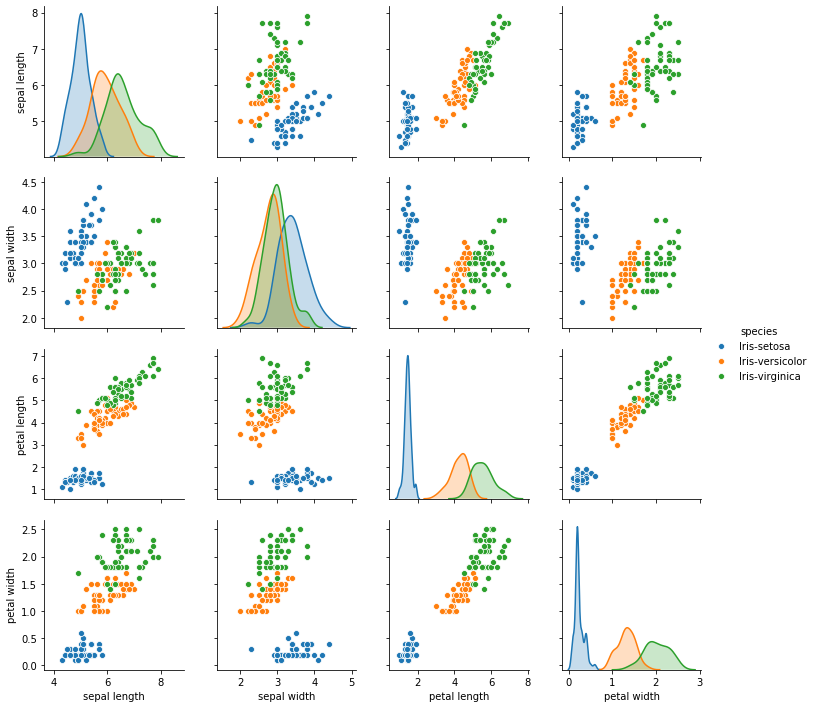

In [84]:
import seaborn as sns
sns.pairplot(data=iris_data,hue='species')

In [282]:
X = iris_data.to_numpy()
y = X[:,-1]
y[y!='Iris-setosa'] = 1
y[y=='Iris-setosa'] = 0

# y[y=='Iris-versicolor'] = 1
# y[y=='Iris-virginica'] = 2
y = y.astype(int)

X = X[:,:-1].astype('float32')

Text(0.5, 1.0, 'Iris dataset')

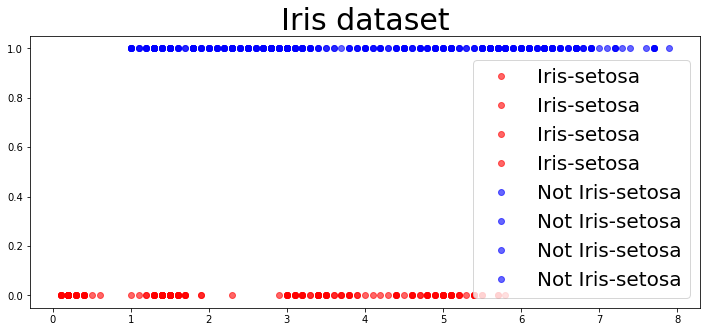

In [317]:
# graph the features in diferent ways to seperate species into 3 clusters
'plot dataset + cluster labels'
colors = ['red','blue']
plt.figure(figsize=(12,5))
labels = ['Iris-setosa', 'Not Iris-setosa']
for i in range(2):
    'plot dataset points'
    plt.plot(X[y==i],y[y==i],'o',color=colors[i],label=labels[i],alpha=0.6)
plt.legend(fontsize=20,loc='lower right')
plt.title('Iris dataset',fontsize=30)

In [284]:
'run k-means with different values for k'
largest_k = 10
k_list = [k+1 for k in range(largest_k)] # [1,2,3,...,largest_k]

inertia_list = []
for k in k_list:
    clusters, means = k_means(X,k)
    inertia_list.append(inertia(X,k,clusters,means))

Text(0.5, 1.0, 'Inertia')

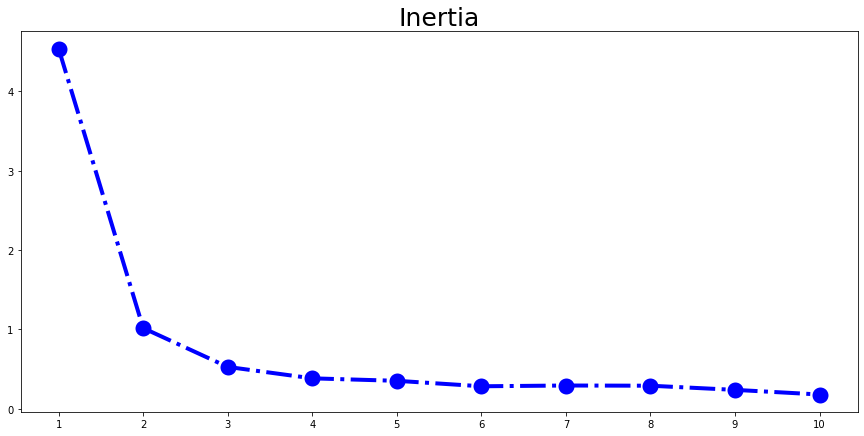

In [285]:
plt.figure(figsize=(15,7))
plt.plot(k_list,inertia_list,'bo-.',markeredgewidth=10,linewidth=4)
plt.xticks(k_list)
plt.title('Inertia',fontsize=25)

In [301]:
'k-means'
k = 2 
clusters, means = k_means(X,k)

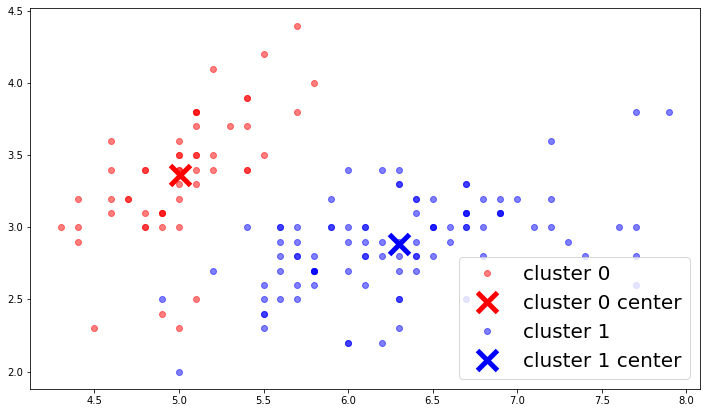

In [302]:
'plot dataset + cluster labels'
colors = ['red','blue']
plt.figure(figsize=(12,7))
for i in range(k):
    'plot dataset points'
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.5)
    'plot cluster means'
    plt.plot(means[i][0],means[i][1],'x',color = colors[i],markersize=20,markeredgewidth=5, label = 'cluster '+str(i)+' center')
    plt.legend(fontsize=20,loc='lower right')

# Notice the above plot only uses features 0 and 1 #
plt.plot(X[clusters==i,0],X[clusters==i,1],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.5)

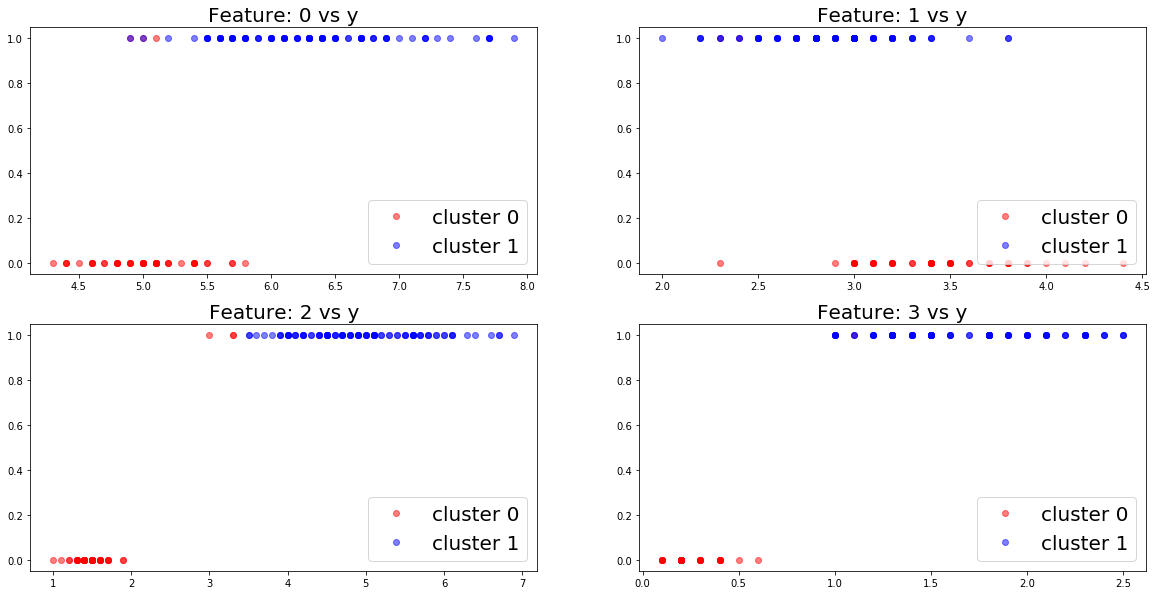

In [303]:
'plot dataset + cluster labels'
colors = ['red','blue']
plt.figure(figsize=(20,10))

for f in range(len(X[0])):    
    plt.subplot(2,2,f+1)
    for i in range(k):
        'plot dataset points'
        plt.plot(X[clusters==i,f],y[clusters==i],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.5)
        plt.legend(fontsize=20,loc='lower right')
    plt.title('Feature: ' + str(f) + ' vs y',fontsize=20)

# Hierarchical Clustering #

In [304]:
k = 2
clusters = hierarchical_clustering(X,k)

Text(0.5, 1.0, 'Iris dataset')

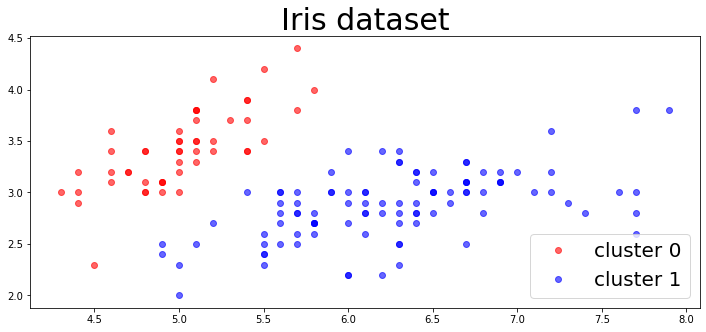

In [318]:
plt.figure(figsize=(12,5))
for i in range(k):
    'plot dataset points'
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o',color=colors[i],label='cluster '+str(i),alpha=0.6)
plt.legend(fontsize=20,loc='lower right')
plt.title('Iris dataset',fontsize=30)

# Notice the above plot only uses features 0 and 1 #
plt.plot(X[clusters==i,0],X[clusters==i,1],'o',color=colors[i],label='cluster '+str(i),alpha=0.6)

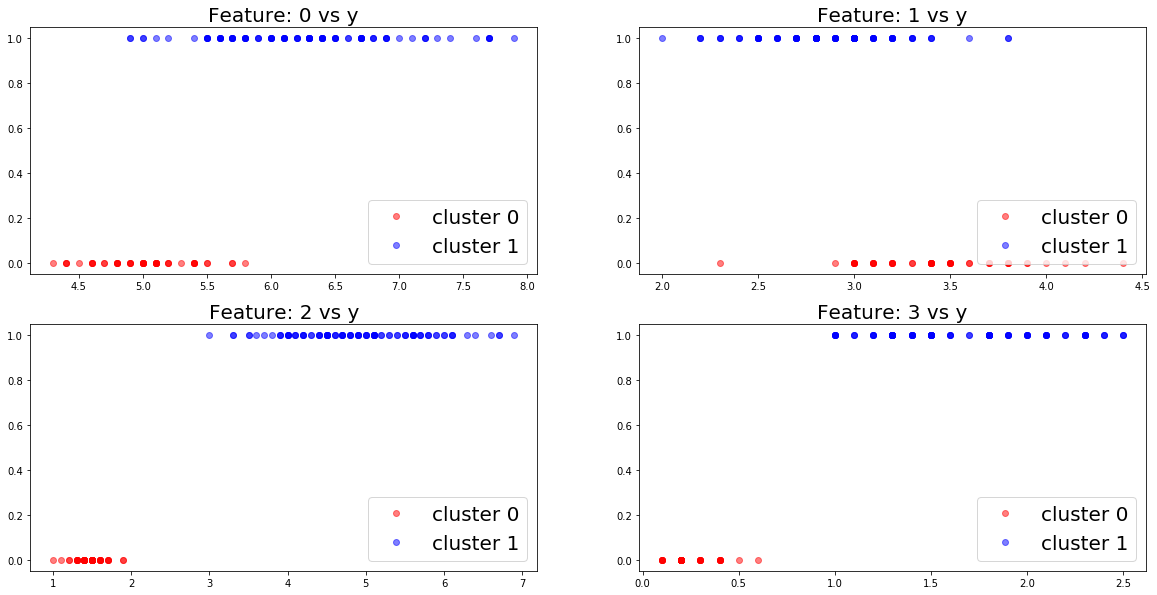

In [306]:
'plot dataset + cluster labels'
colors = ['red','blue']
plt.figure(figsize=(20,10))

for f in range(len(X[0])):    
    plt.subplot(2,2,f+1)
    for i in range(k):
        'plot dataset points'
        plt.plot(X[clusters==i,f],y[clusters==i],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.5)
        plt.legend(fontsize=20,loc='lower right')
    plt.title('Feature: ' + str(f) + ' vs y',fontsize=20)
    



Text(0.5, 1.0, 'Iris dataset')

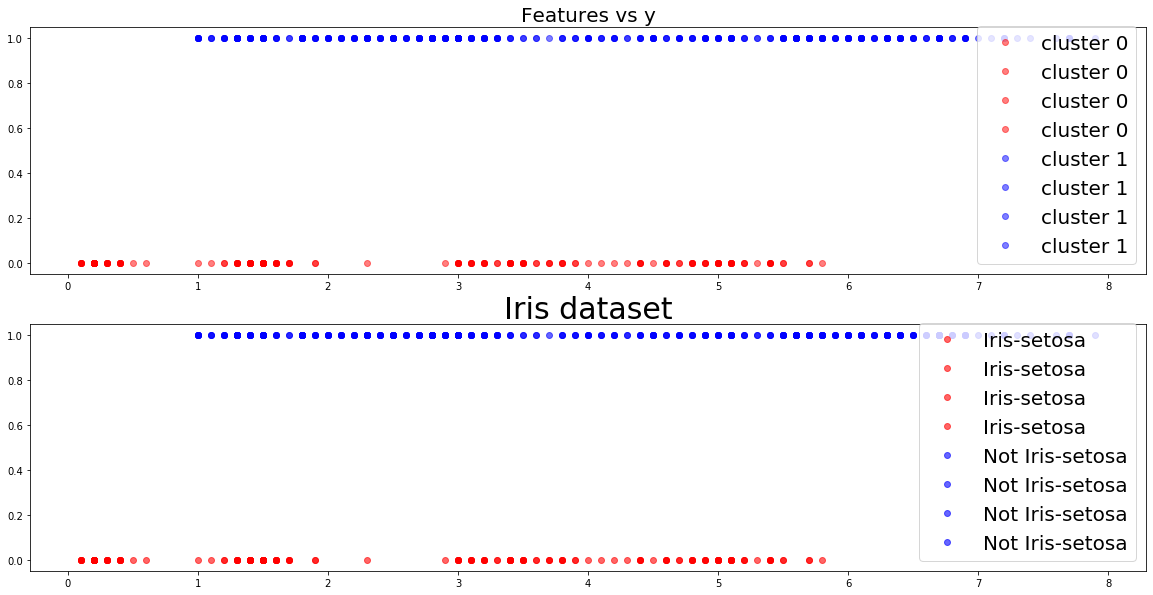

In [322]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
for i in range(k):
    'plot dataset points'
    plt.plot(X[clusters==i],y[clusters==i],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.5)
    plt.legend(fontsize=20,loc='lower right')
plt.title('Features vs y',fontsize=20)

plt.subplot(2,1,2)
for i in range(2):
    'plot dataset points'
    plt.plot(X[y==i],y[y==i],'o',color=colors[i],label=labels[i],alpha=0.6)
plt.legend(fontsize=20,loc='lower right')
plt.title('Iris dataset',fontsize=30)

## Problem 2: Clustering for Color Segmentation

*Image segmentation* is the task of partitioning an image into multiple segments. 
In *color segmentation*, all pixels that are part of the same segments get assigned to the same color.

Load the ladybug image:

In [349]:
from matplotlib.image import imread
url = 'https://raw.githubusercontent.com/um-perez-alvaro/clustering/master/ladybug.png'
image = imread(url)

The image is represented as a 3D array

In [350]:
image.shape

(533, 800, 3)

The first dimension's size is the height; the second is the width; and the third is the number of color channels, in this case red, green and blue (RGB)

(-0.5, 799.5, 532.5, -0.5)

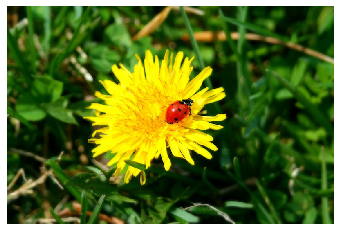

In [351]:
plt.imshow(image)
plt.axis('off')

The following code reshapes the array to get a long list of RGB colors (The resulting matrix $X$ has one row for each pixel)

In [352]:
X = image.copy().reshape(-1,3)
X.shape

(426400, 3)

Cluster the pixels (i.e., the rows of $X$) using the k-means algorithm.
Next, replace each pixel (i.e., each row of $X$) by its cluster mean. 
Plot the resulting image for k=2, 4, 6, 8, 10 and 12. 

# The next cell is very slow #

In [370]:
ks = [2,4,6,8,10,12]
cluster_list = []
means_list = []
for f in range(len(ks)):
    k = ks[f]
    x = X.copy()
    clusters, means = k_means(x,k)    
    cluster_list.append(clusters)
    means_list.append(means)

(-0.5, 799.5, 532.5, -0.5)

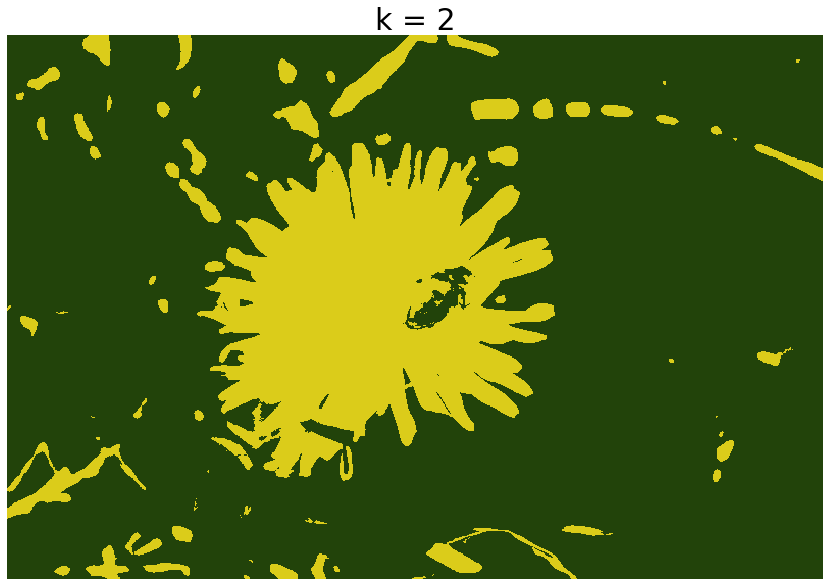

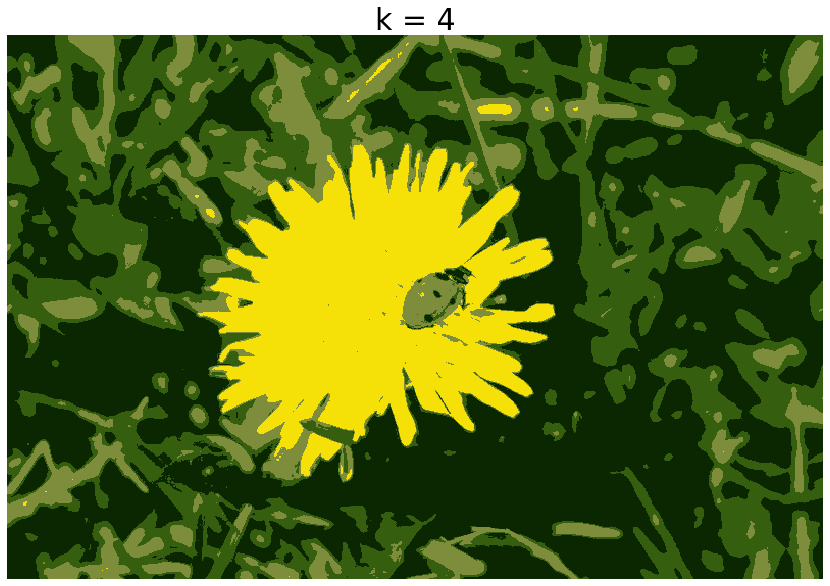

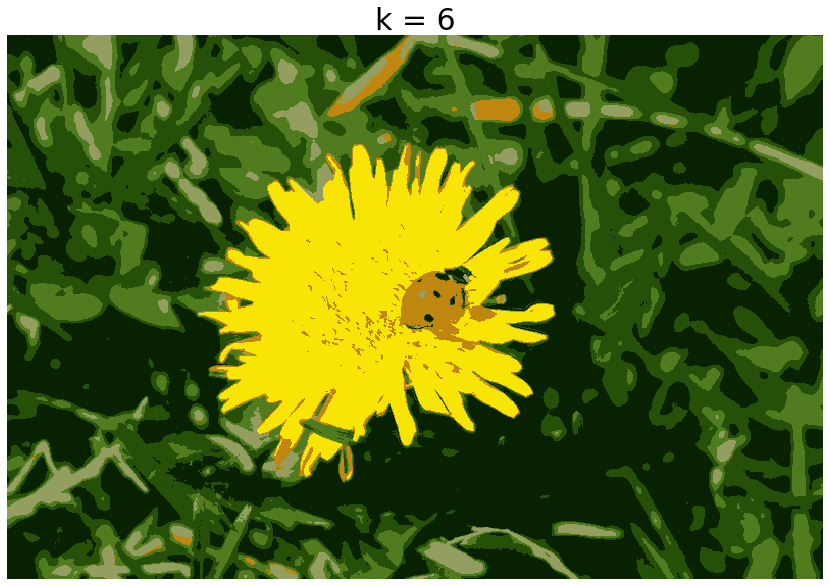

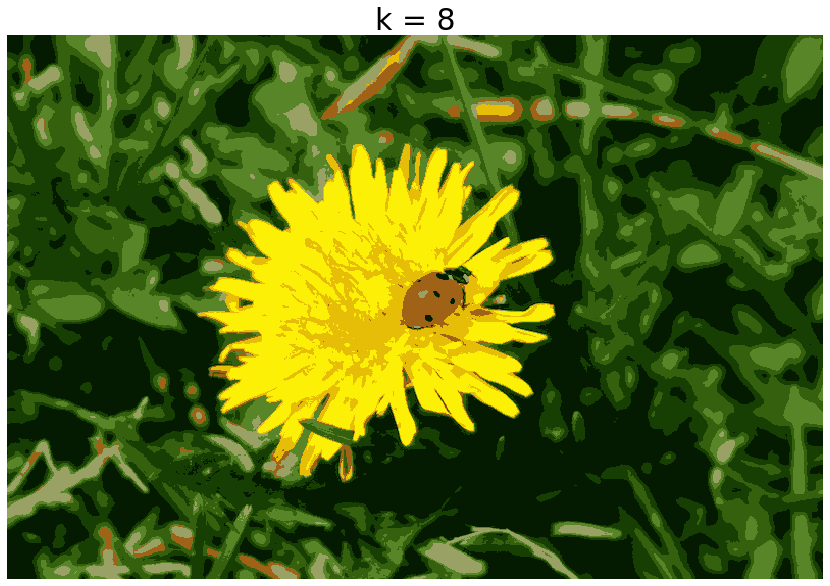

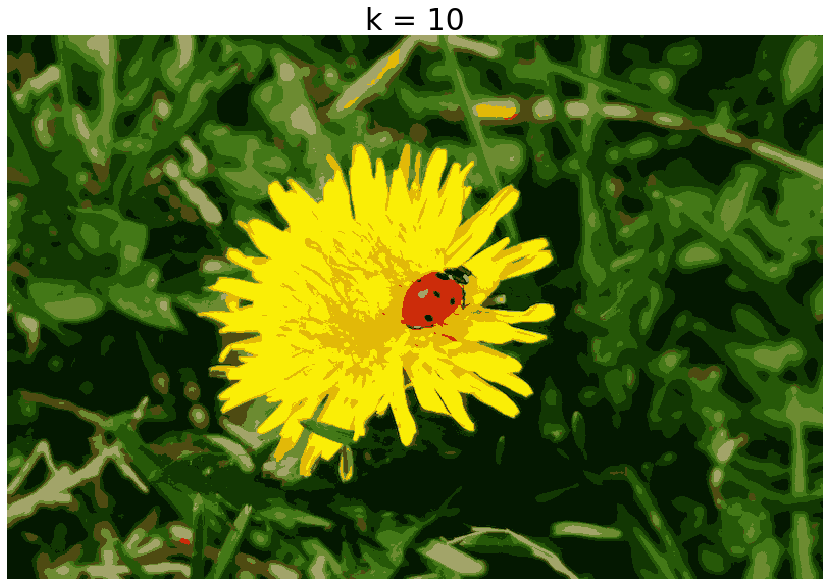

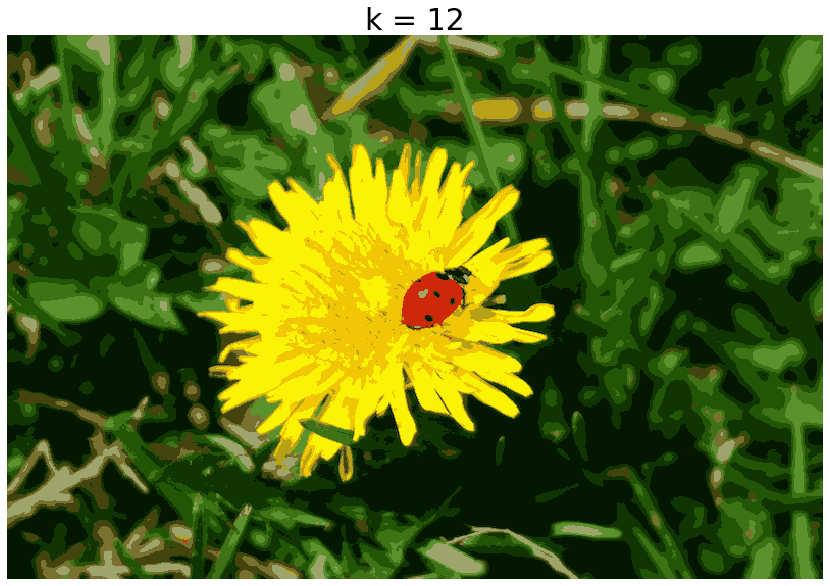

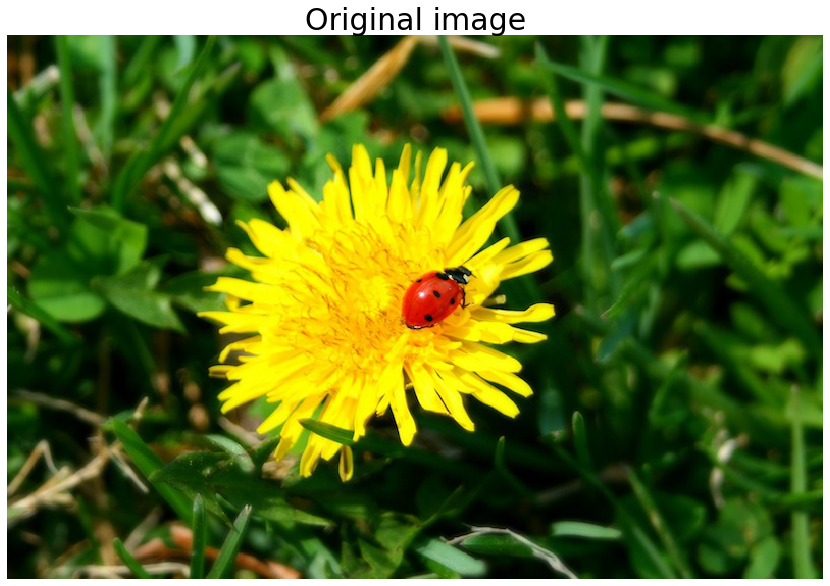

In [379]:
for f in range(len(ks)):
    k = ks[f]
    for i in range(k): # ks[f]
        x[cluster_list[f]==i] = means_list[f][i]
    plt.figure(figsize=(20,10))
    plt.imshow(x.reshape(533,800,3))
    plt.title('k = ' + str(k),fontsize=30)
    plt.axis('off')

plt.figure(figsize=(20,10))
plt.imshow(X.reshape(533,800,3))
plt.title('Original image',fontsize=30)
plt.axis('off')

## Problem 3: the Olivetti Faces Dataset

The Olivetti faces dataset contains 400 grayscale 64 × 64 pixel images of faces. 
Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each).

In [3]:
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces()
images, labels = data.images, data.target

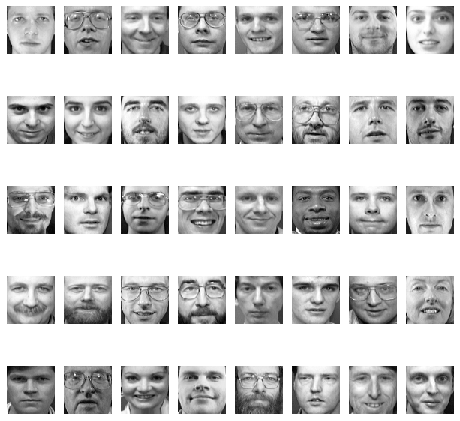

In [4]:
plt.figure(figsize=(8,8))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.imshow(images[i*10],cmap='gray')
    plt.axis('off')

Cluster the images using k-means or hierarchical clustering, and ensure that you have a good number of clusters using the silhouette score method.
 You might expect the optimal number of clusters to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

Visualize the clusters: do you see similar faces in each cluster?

In [5]:
images.shape

(400, 64, 64)

In [9]:
X = images.copy()
X = X.reshape(-1,64)
X.shape


(25600, 64)

# Counl't get next cell to finish running #

In [ ]:
clusters, s_scores = hierarchical_clustering_with_s_score(X)

In [ ]:
iterations = np.arange(X.shape[0])

plt.figure(figsize=(12,5))
plt.plot(iterations,s_scores,'bo-.')
plt.xlabel('iteration',fontsize=20)
plt.ylabel('silhouette scores',fontsize=20)

# 254 from using 3

In [42]:
s_scores.argmax()

254

Text(0, 0.5, 'silhouette scores')

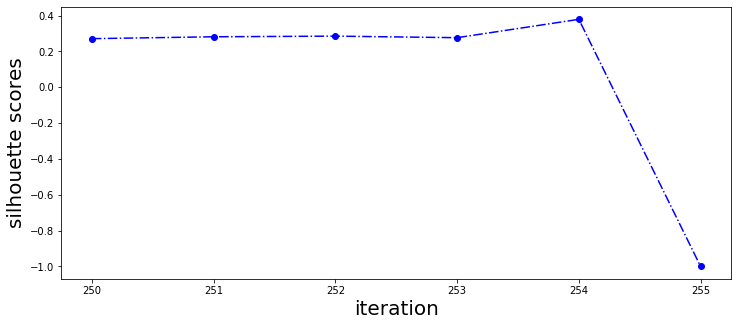

In [44]:
iterations = np.arange(X.shape[0])

plt.figure(figsize=(12,5))
plt.plot(iterations[250:],s_scores[250:],'bo-.')
plt.xlabel('iteration',fontsize=20)
plt.ylabel('silhouette scores',fontsize=20)

## Problem 4: Playing with Spectral Clustering

Use spectral clustering to find the two clusters in the following datasets.

**Dataset 1: Eye of Sauron**

Text(0.5, 1.0, 'Eye of Sauron')

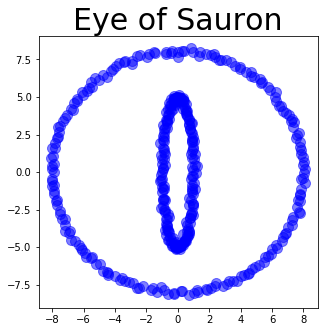

In [2]:
X = np.zeros((400,2))

# cluster 1:
theta = np.linspace(0,2*np.pi,200) 
X[0:200,0] = 8*np.sin(theta)+0.1*np.random.randn(200)
X[0:200,1] = 8*np.cos(theta)+0.1*np.random.randn(200)
# cluster 2:
X[200:400,0] = 1*np.sin(theta)+0.1*np.random.randn(200)
X[200:400,1] = 5*np.cos(theta)+0.1*np.random.randn(200)

plt.figure(figsize=(5,5))
plt.plot(X[:,0],X[:,1],'bo',alpha=0.5,markersize=10)
plt.title('Eye of Sauron',fontsize=30)

Text(0.5, 1.0, 'transformed dataset')

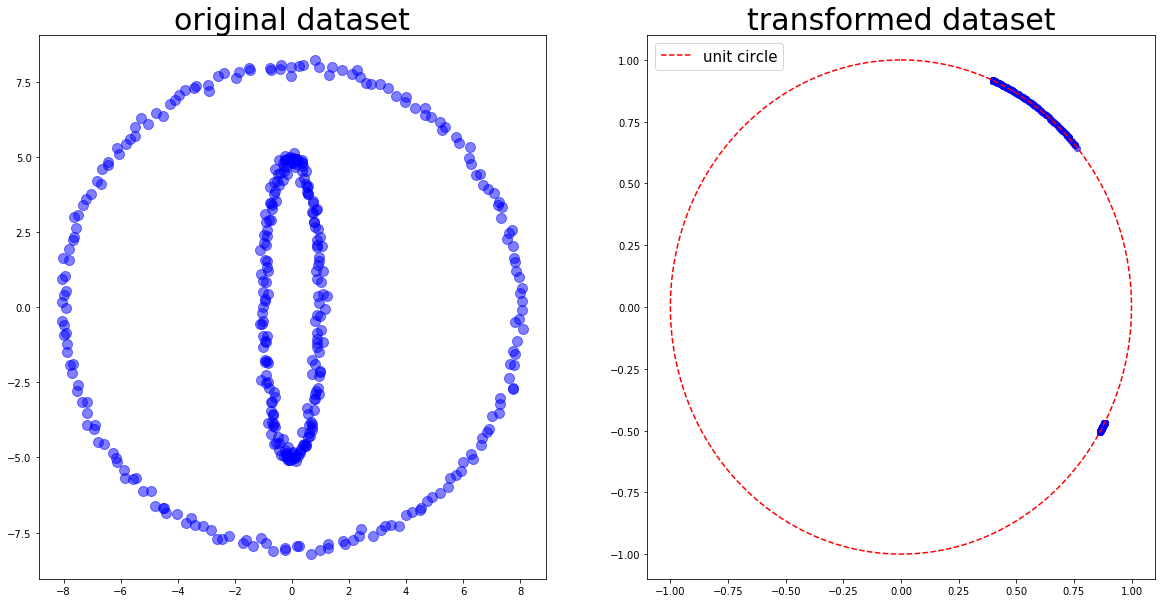

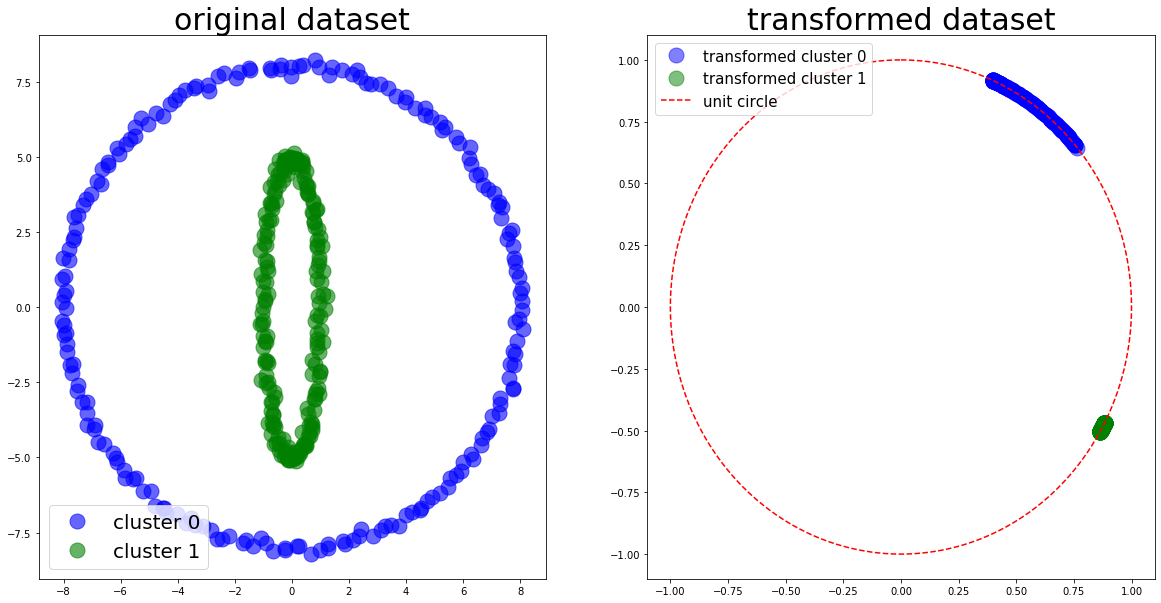

In [4]:
sigma = 0.5
k = 2
clusters, V = spectral_clustering(X,k,sigma)

plt.figure(figsize=(20,10))

'original dataset'
plt.subplot(1,2,1)
plt.plot(X[:,0],X[:,1],'bo',alpha=0.5,markersize=10)
plt.title('original dataset',fontsize=30)

'transformed dataset + unit circle'
theta = np.linspace(0,2*np.pi,1000) 
x_unit_circle = np.sin(theta)
y_unit_circle = np.cos(theta)
plt.subplot(1,2,2)
plt.plot(V[:,0],V[:,1],'bo',alpha=0.6)
plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
plt.legend(fontsize=15,loc='upper left')
plt.title('transformed dataset',fontsize=30)

plt.figure(figsize=(20,10))

'original dataset'
plt.subplot(1,2,1)
colors = ['blue','green']
k=2
for i in range(k):
    'plot dataset points'
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.6,markersize=15)
    plt.legend(fontsize=20, loc='lower left')
plt.title('original dataset',fontsize=30)

'transformed dataset + unit circle'
theta = np.linspace(0,2*np.pi,1000) 
x_unit_circle = np.sin(theta)
y_unit_circle = np.cos(theta)
plt.subplot(1,2,2)
for i in range(k):
    plt.plot(V[clusters==i,0],V[clusters==i,1],'o',color=colors[i],label = 'transformed cluster '+str(i),alpha=0.5,markersize=15)
    plt.legend(fontsize=20, loc='lower left')

plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
plt.legend(fontsize=15,loc='upper left')
plt.title('transformed dataset',fontsize=30)


**Dataset 2: connected circles**

Text(0.5, 1.0, 'Connected circles')

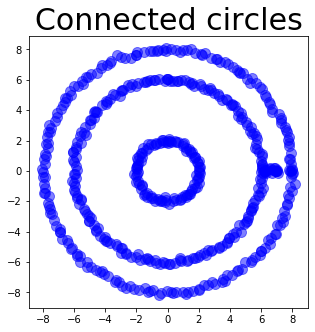

In [5]:
X = np.zeros((525,2))

# cluster 1:
theta = np.linspace(0,2*np.pi,200) 
X[0:200,0] = 8*np.sin(theta)+0.1*np.random.randn(200)
X[0:200,1] = 8*np.cos(theta)+0.1*np.random.randn(200)

X[200:400,0] = 6*np.sin(theta)+0.1*np.random.randn(200)
X[200:400,1] = 6*np.cos(theta)+0.1*np.random.randn(200)

X[400:425,0] = 6 + 2*np.random.rand(25)
X[400:425,1] = 0.1*np.random.randn(25)

# cluster 2:
theta = np.linspace(0,2*np.pi,100)
X[425:525,0] = 2*np.sin(theta)+0.1*np.random.randn(100)
X[425:525,1] = 2*np.cos(theta)+0.1*np.random.randn(100)

plt.figure(figsize=(5,5))
plt.plot(X[:,0],X[:,1],'bo',alpha=0.5,markersize=10)
plt.title('Connected circles',fontsize=30)

Text(0.5, 1.0, 'transformed dataset')

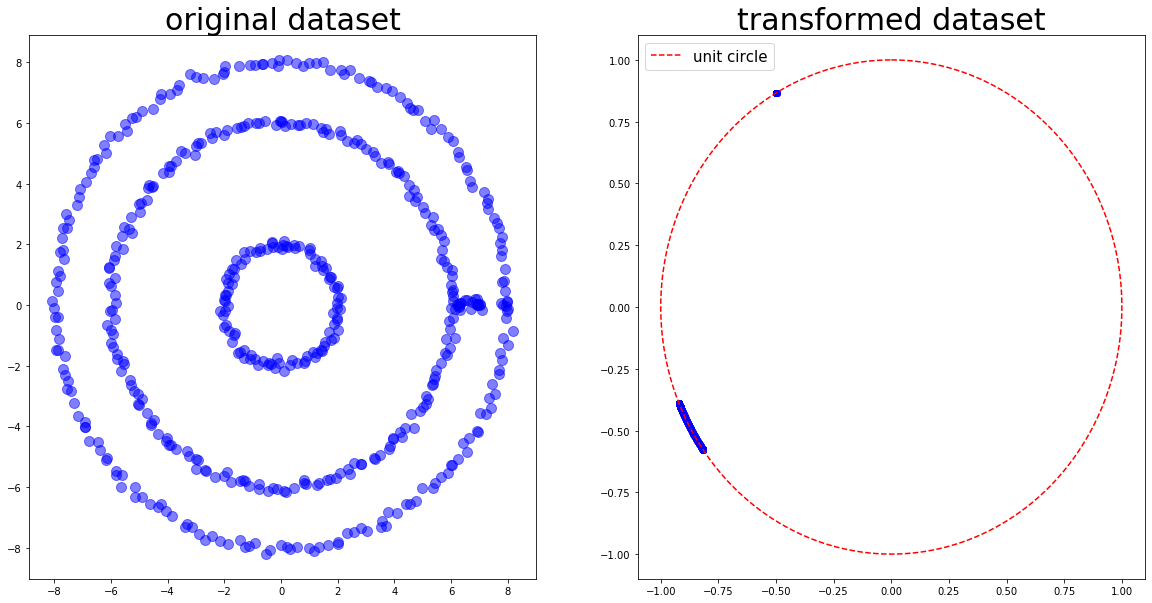

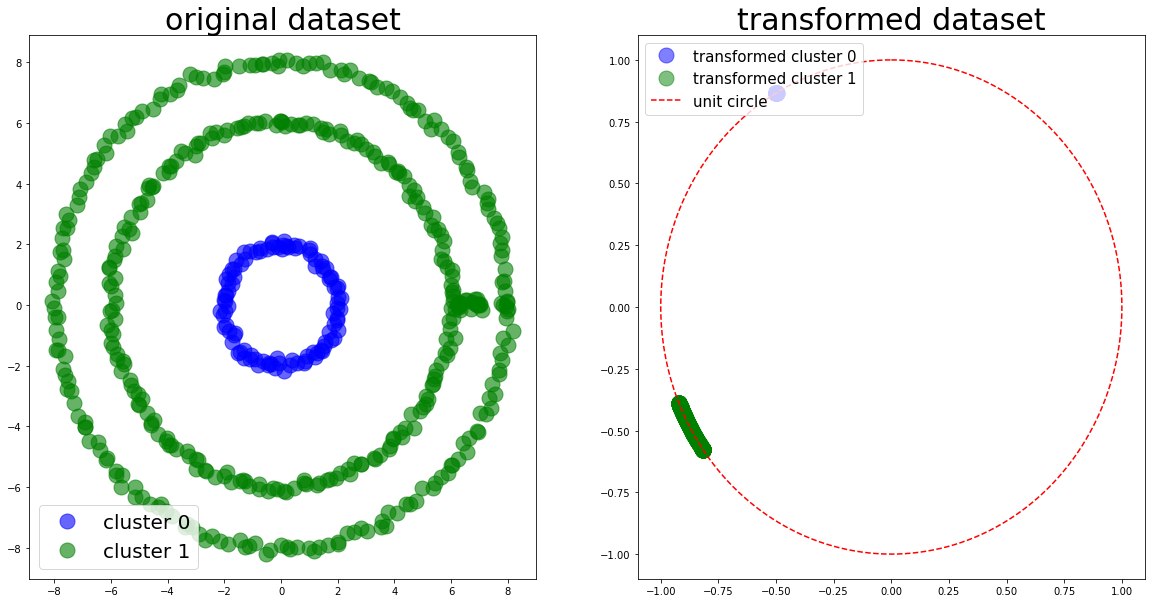

In [6]:
sigma = 0.5
k = 2
clusters, V = spectral_clustering(X,k,sigma)

plt.figure(figsize=(20,10))

'original dataset'
plt.subplot(1,2,1)
plt.plot(X[:,0],X[:,1],'bo',alpha=0.5,markersize=10)
plt.title('original dataset',fontsize=30)

'transformed dataset + unit circle'
theta = np.linspace(0,2*np.pi,1000) 
x_unit_circle = np.sin(theta)
y_unit_circle = np.cos(theta)
plt.subplot(1,2,2)
plt.plot(V[:,0],V[:,1],'bo',alpha=0.6)
plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
plt.legend(fontsize=15,loc='upper left')
plt.title('transformed dataset',fontsize=30)

plt.figure(figsize=(20,10))

'original dataset'
plt.subplot(1,2,1)
for i in range(k):
    'plot dataset points'
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.6,markersize=15)
    plt.legend(fontsize=20, loc='lower left')
plt.title('original dataset',fontsize=30)

'transformed dataset + unit circle'
theta = np.linspace(0,2*np.pi,1000) 
x_unit_circle = np.sin(theta)
y_unit_circle = np.cos(theta)
plt.subplot(1,2,2)
for i in range(k):
    plt.plot(V[clusters==i,0],V[clusters==i,1],'o',color=colors[i],label = 'transformed cluster '+str(i),alpha=0.5,markersize=15)
    plt.legend(fontsize=20, loc='lower left')

plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
plt.legend(fontsize=15,loc='upper left')
plt.title('transformed dataset',fontsize=30)


**Dataset 3: interlocked rings (3D)**

In [7]:
from mpl_toolkits.mplot3d import Axes3D 
#the next line will allow you to rotate the 3d graph
# %matplotlib notebook 

Text(0.5, 0.92, 'Interlocked rings')

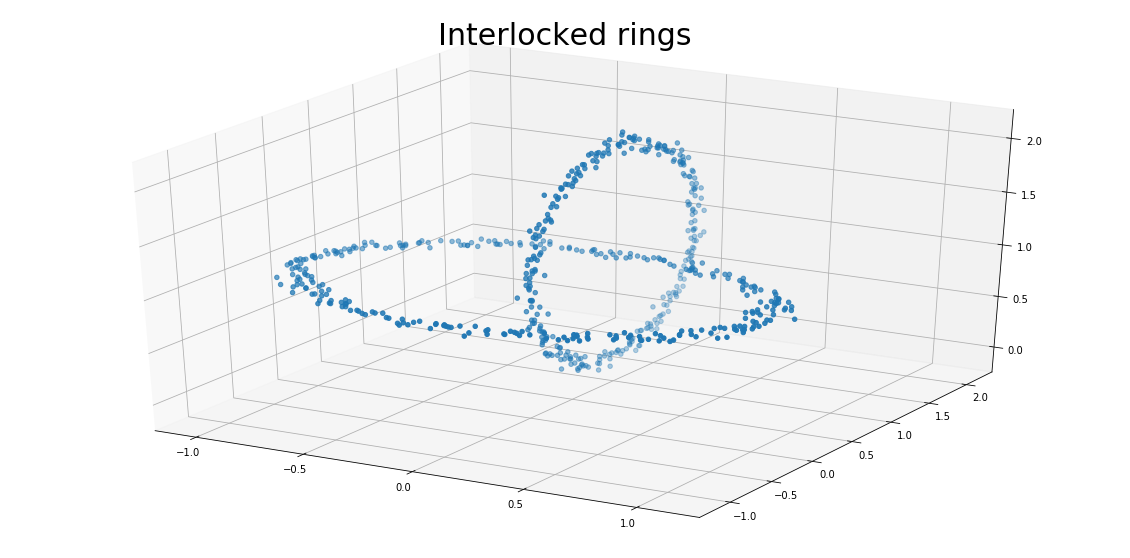

In [27]:
X = np.zeros((600,3))

# cluster 1:
theta = np.linspace(0,2*np.pi,300) 
X[0:300,0] = np.sin(theta)+0.05*np.random.randn(300)
X[0:300,1] = np.cos(theta)+0.05*np.random.randn(300)
X[0:300,2] = np.ones(300)

# cluster 2:
X[300:600,0] = np.zeros(300)
X[300:600,1] = np.sin(theta)+1+0.05*np.random.randn(300)
X[300:600,2] = np.cos(theta)+1+0.05*np.random.randn(300)

plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])
plt.title('Interlocked rings',fontsize=30)

In [28]:
sigma = 0.2
k = 2
clusters, V = spectral_clustering(X,k,sigma)

Text(0.5, 0.92, 'Interlocked rings')

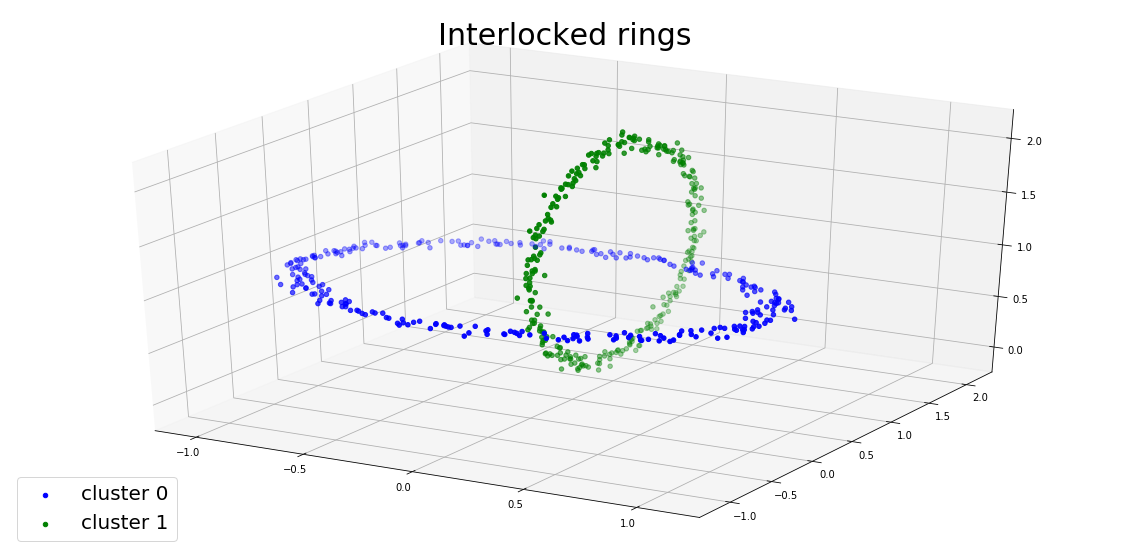

In [29]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
for i in range(k):
    'plot dataset points'
    ax.scatter(X[clusters==i,0],X[clusters==i,1],X[clusters==i,2],'o',color=colors[i],label = 'cluster '+str(i))
    ax.legend(fontsize=20, loc='lower left')
plt.title('Interlocked rings',fontsize=30)



## Problem 5: Greedy Initialization of k-means

Consider the following initialization method which we denote as the *greedy* initialization method:

1. For the first cluster center, pick one of the dataset points at random.

2. Pick each remaining cluster center as the dataset point as far from the remaining centroids as possible.

Consider the following dataset:

<IPython.core.display.Javascript object>


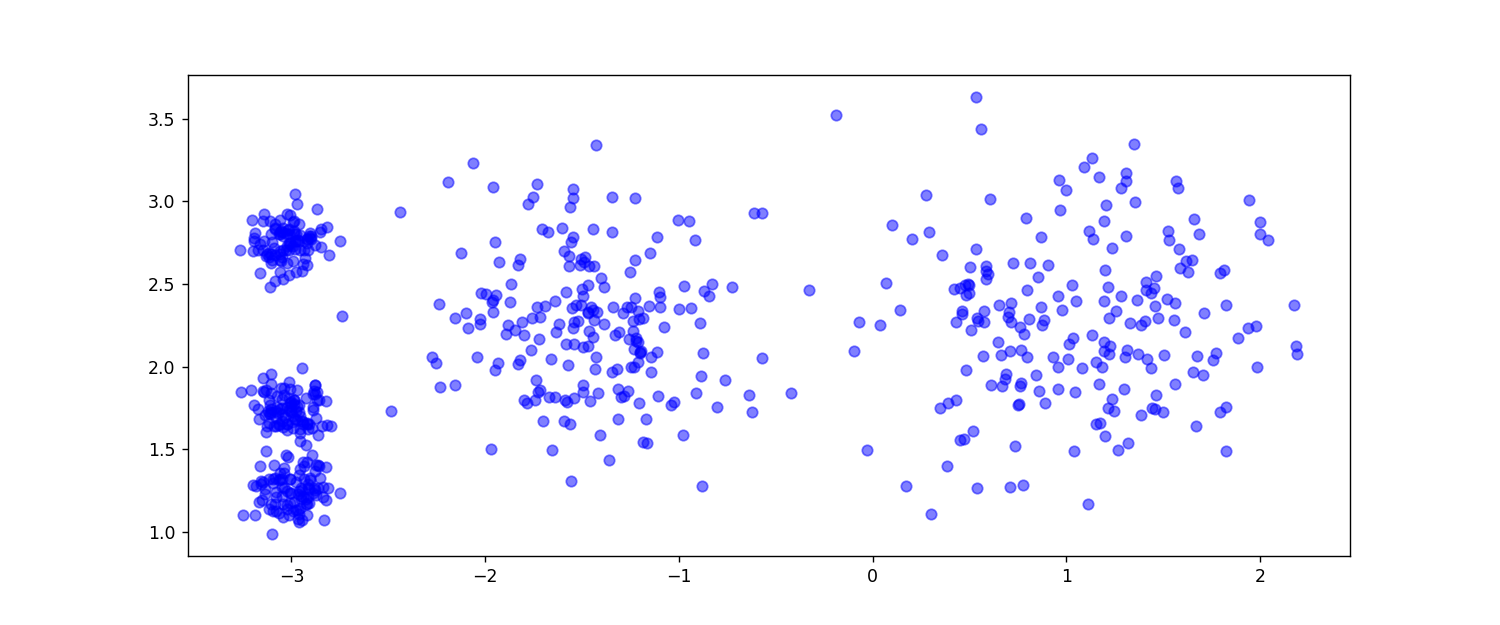

In [30]:
X = np.zeros((700,2))

X[:100] = 0.1*np.random.randn(100,2) + [-3,1.25] # blob 1
X[100:200] = 0.1*np.random.randn(100,2) + [-3,1.75] # blob 2
X[200:300] = 0.1*np.random.randn(100,2) + [-3,2.75] # blob 3
X[300:500] = 0.4*np.random.randn(200,2) + [-1.5,2.25] # blob 4
X[500:700] = 0.5*np.random.randn(200,2) + [1,2.25] # blob 5

plt.figure(figsize=(12,5))
plt.plot(X[:,0],X[:,1],'bo',alpha=0.5)

Plot the k-means' initial clusters (with $k=5$) if:

1. the initial cluster's centers are randomly chosen from the dataset points

2. the initial cluster's centers are chosen using the greedy initialization